<IPython.core.display.Javascript object>


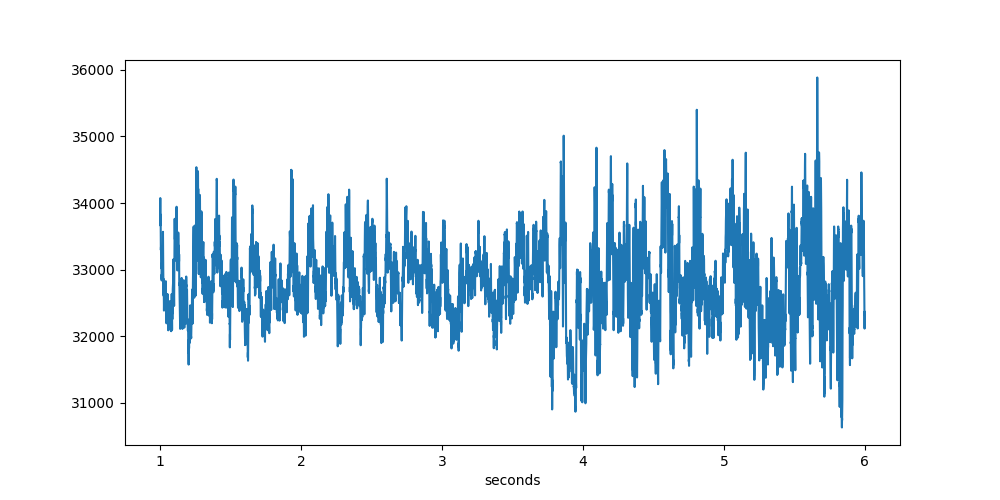

Text(0.5,0,'seconds')

In [22]:
import numpy as np
import scipy.io as sio
from scipy.signal import hilbert
import matplotlib.pyplot as plt
import matplotlib.animation as animation
% matplotlib notebook

def discretize_gamma_theta_peaks(signal, Fs=2000, Fds=100, Fbn=20):
    # returns raster of peaks of gamma filteed envelope and theta filtered signal
    # INPUTS:
    # signal  -  continuous LFP signal
    # Fs  -  sampling fq of LFP signal (Hz)
    # Fds  -  downsampled frequency (Hz)
    # Fbn  -  Binning frequency(for binning peak times)
    # Generally Fs > Fds > Fbn
    
    # Note: find_peaks height & distance params have been fine tuned to work at 100Hz
    
    from scipy.signal import hilbert, butter, filtfilt, find_peaks, find_peaks_cwt

    def butter_bandpass(lowcut, highcut, Fs, order=5):
        nyq = 0.5 * Fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = butter(order, [low, high], btype='band')
        return b, a

    dur = len(signal)/Fs # total duration of signal in s
    tvec = np.arange(0,dur,1/Fs) # time vector
    step = int(Fs/Fds) # step size to downsample at desired freuqency
    tvec_ds = tvec[::step] # downsampled
    
    # mean center and normalize
    signal = signal - np.mean(signal)
    signal = signal/np.max(signal)

    # Gamma fq
    b, a = butter_bandpass(40,60,Fs,order=5)
    signal_gamma = filtfilt(b, a, signal)
    
    # Theta frequency (add smoothing by convolution)
    b, a = butter_bandpass(1,20,Fs,order=3)
    signal_theta = filtfilt(b, a, signal)
    signal_theta = np.convolve(signal_theta, np.ones(120)/120, mode='same')

    # Gamma envelope
    gamma_analytic_signal = hilbert(signal_gamma)
    gamma_amplitude_envelope = np.abs(gamma_analytic_signal)
    
    # Find peaks of gamma filtered env
    gamma_env_ds = gamma_amplitude_envelope[::step]
    peaks,_ = find_peaks(gamma_env_ds,height=0)
    gamma_env_peak_times = tvec_ds[peaks]
    gamma_env_peak_hights = gamma_env_ds[peaks]
    
    # Find peaks of theta filltered signal
    theta_filt_ds = signal_theta[::step]
    peaks,_ = find_peaks(theta_filt_ds,distance=10)
    theta_filt_peak_times = tvec_ds[peaks]
    theta_filt_peak_hights = theta_filt_ds[peaks]
    
    
    # downsampled frequency (used for plotting)
    binned_gamma = np.histogram(gamma_env_peak_times,np.arange(0,dur+(1/Fds),1/Fds))[0]
    masked_gamma_env = np.multiply(gamma_env_ds,binned_gamma)
    masked_gamma_env = np.where(masked_gamma_env==0,np.nan,masked_gamma_env) # set 0s to nan
    binned_theta = np.histogram(theta_filt_peak_times,np.arange(0,dur+(1/Fds),1/Fds))[0]
    masked_theta_filt = np.multiply(theta_filt_ds,binned_theta)
    masked_theta_filt = np.where(masked_theta_filt==0,np.nan,masked_theta_filt) # set 0s to nan
    
    # # Bin gamma env & theta filt into rasters (used for sonification)
    #binned_gamma_sonify = np.histogram(gamma_env_peak_times,int(dur*Fbn))[0] # using nbins
    #binned_theta_sonify = np.histogram(theta_filt_peak_times,int(dur*Fbn))[0] # using nbins
    binned_gamma_sonify = np.histogram(gamma_env_peak_times,np.arange(0,dur+(1/Fbn),1/Fbn))[0] # using edges
    binned_theta_sonify = np.histogram(theta_filt_peak_times,np.arange(0,dur+(1/Fbn),1/Fbn))[0] # using edges
    
    
    out_dict = {
            'tvec_ds':tvec_ds,
            'gamma_env_ds':gamma_env_ds,
            'gamma_env_peak_times':gamma_env_peak_times,
            'gamma_env_peak_hights':gamma_env_peak_hights,
            'theta_filt_ds':theta_filt_ds,
            'theta_filt_peak_times':theta_filt_peak_times,
            'theta_filt_peak_hights':theta_filt_peak_hights,
            'masked_gamma_env':masked_gamma_env,
            'masked_theta_filt':masked_theta_filt,
            'binned_gamma_sonify':binned_gamma_sonify,
            'binned_theta_sonify':binned_theta_sonify,
            'binned_theta':binned_theta
                }
    return out_dict
    

OB_5min = sio.loadmat('/Users/brainbow/Documents/LFP sonification/mat_files/OB_5min.mat')['OB_5min'][0]

Fs = 2000 # Hz
tvec = np.arange(0,len(OB_5min)/Fs,1/Fs)
win = range(2000,12000)
# win = range(2000,6000)

#win = range(22000,212000)

signal = OB_5min[win]
tvec = tvec[win]

plt.figure(figsize=(10,5))
plt.plot(tvec,signal)
plt.xlabel('seconds')

# Plot theta filtered and gamma env signlas

In [23]:
out_dict = discretize_gamma_theta_peaks(signal, Fs=2000, Fds=100, Fbn=20)
out_dict.keys()

dict_keys(['tvec_ds', 'gamma_env_ds', 'gamma_env_peak_times', 'gamma_env_peak_hights', 'theta_filt_ds', 'theta_filt_peak_times', 'theta_filt_peak_hights', 'masked_gamma_env', 'masked_theta_filt', 'binned_gamma_sonify', 'binned_theta_sonify', 'binned_theta'])

In [24]:
offset = 0.5
gs = 3 # gamma scale
plt.figure(figsize=(10,5))
plt.plot(out_dict['tvec_ds'],out_dict['theta_filt_ds'])
plt.plot(out_dict['tvec_ds'],offset+3*out_dict['gamma_env_ds'])
plt.plot(out_dict['tvec_ds'],out_dict['masked_theta_filt'], "o",markersize=5, markerfacecolor='w') # plot masked time series rather than amplitude at peaks
#plt.plot(out_dict['theta_filt_peak_times'],out_dict['theta_filt_peak_hights'], "x")
plt.plot(out_dict['tvec_ds'],offset+3*out_dict['masked_gamma_env'], "o",markersize=5, markerfacecolor='w')
#plt.plot(out_dict['gamma_env_peak_times'], offset+3*out_dict['gamma_env_peak_hights'], "x")
plt.xlabel('Time (s)',fontsize=14)
#plt.yticks([])

<IPython.core.display.Javascript object>

Text(0.5,0,'Time (s)')

<IPython.core.display.Javascript object>


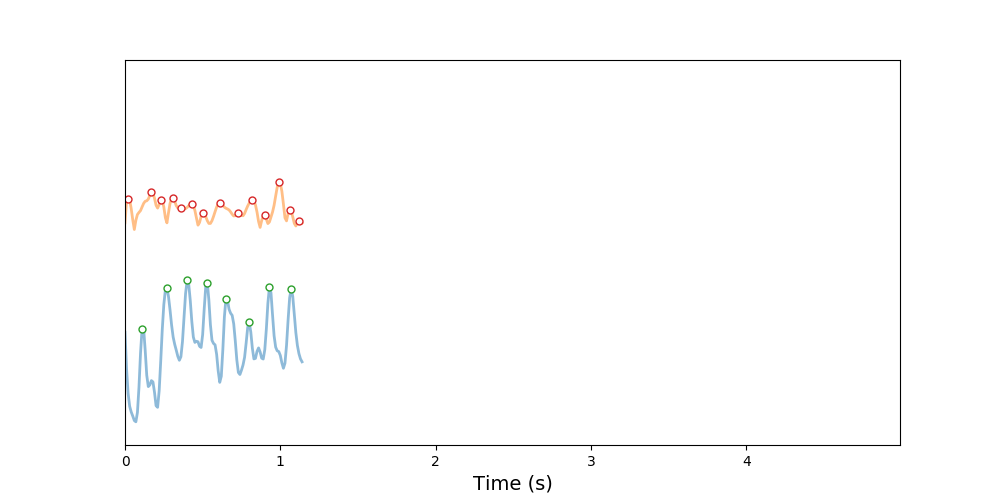

In [15]:
"""
Matplotlib Animation Example

author: Jake Vanderplas
email: vanderplas@astro.washington.edu
website: http://jakevdp.github.com
license: BSD
Please feel free to use and modify this, but keep the above information. Thanks!
"""

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure(figsize=(10,5))
ax = plt.axes(xlim=(0, out_dict['tvec_ds'][-1]),ylim=(-0.5, 0.7))
line_theta, = ax.plot([], [], lw=2, alpha=0.5)
line_gamma, = ax.plot([], [], lw=2, alpha=0.5)
peaks_theta, = ax.plot([], [],"o", lw=2, markersize=5, markerfacecolor='w')
peaks_gamma, = ax.plot([], [],"o", lw=2, markersize=5, markerfacecolor='w')
ax.set_xlabel('Time (s)',fontsize=14)
ax.set_yticks([])
ax.set_ylim([-0.5,1.3])

# initialization function: plot the background of each frame
def init():
    line_theta.set_data([], [])
    line_gamma.set_data([], [])
    peaks_theta.set_data([], [])
    peaks_gamma.set_data([], [])
    return line_theta,line_gamma,peaks_theta,peaks_gamma

# animation function.  This is called sequentially
def animate(i):
    gxo = 0.5 # gamma x-axis offset
    gs = 3 # gamma scale
    
    x = out_dict['tvec_ds'][:int(i)]
    line_theta.set_data(x, out_dict['theta_filt_ds'][:int(i)])
    line_gamma.set_data(x, gxo + gs*out_dict['gamma_env_ds'][:int(i)])
    peaks_theta.set_data(x, out_dict['masked_theta_filt'][:int(i)])
    peaks_gamma.set_data(x, gxo + gs*out_dict['masked_gamma_env'][:int(i)])
    
    return line_theta,line_gamma,peaks_theta,peaks_gamma

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(out_dict['tvec_ds']), interval=20, blit=True)

# save the animation as an mp4.  This requires ffmpeg or mencoder to be
# installed.
# https://superuser.com/questions/624561/install-ffmpeg-on-os-x
# The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5.  You may need to adjust this for
# your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html
anim.save('gamma_theta_peaks_40fps.mp4', fps=40, extra_args=['-vcodec', 'libx264'])



In [ ]:
# ffmpeg -i '/Users/brainbow/Documents/LFP sonification/gamma_theta_peaks_40fps.mp4' -i '/Users/brainbow/Music/SuperCollider Recordings/kick_hat_correct_binning_13s.aiff' -c:v copy -c:a aac /Users/brainbow/Documents/sonified_lfp.mp4

# The audio file extends ever so slightly after the video